In [2]:
# library(reshape2)
library(ggplot2)
library(tibble)

In [551]:
stable.sigmoid <- function(x) 
{
    if (x >= 0) 
        {1 / (1 + exp(-x))}
    else 
        {exp(x) / (1 + exp(x))}
}
sigmoid <- function(x) {sapply(x, stable.sigmoid)}

logreg.nll <- function(X, y, beta) 
{
    y.hat <- X%*%beta
    -sum(y * y.hat + log(sigmoid(-y.hat )))
}

grad.beta <- function(X, y, beta) {-as.numeric(c(y - sigmoid(X %*% beta)) %*% X)}

l2.norm <- function(a) {sqrt(sum(a*a))}

hess.loss.max <- function(X)
{
    hess.loss = 2 * (t(X) %*% X)
    hess.ev = eigen(hess.loss)$values
    return(max(hess.ev))
}

In [552]:
generate_data <- function(n, d, seed = 42) 
{
    set.seed(seed)
    X <- matrix(rnorm(n*d), nrow = n, ncol = d)
    beta <- rep(1 / sqrt(d), d)
    y <- rbinom(n, size = 1, sigmoid(X %*% beta))
    list(X=X, y=y, beta=beta)
}
data <- generate_data(2000, 20)

In [553]:
gd_step.accelerated <- function(X, y, beta_, beta_prev, t, k)
{
    v <- beta_+(k/(k+3))*(beta_-beta_prev)
    return(v-t*grad.beta(X, y, v))
}   

gd_step.SGD <- function(X, y, beta_, t, batch_size)
{
    shuffle.idx <- sample(1:dim(X)[1], batch_size, replace=FALSE)
    X <- X[shuffle.idx, ]
    y <- y[shuffle.idx]
    return(beta_-t*grad.beta(X, y, beta_))
}

gd_step.SVRG <- function(X, y, beta_, beta_prev, eta, batch_size, update_freq)
{
    mu <- grad.beta(X, y, beta_prev)
    for (j in 1:update_freq)
    {
        shuffle.idx <- sample(1:dim(X)[1], batch_size, replace=FALSE)
        X_ <- X[shuffle.idx, ]
        y_ <- y[shuffle.idx]
        beta_ <- beta_-eta*(grad.beta(X_, y_, beta_)-grad.beta(X_, y_, beta_prev)+mu)
    }
    return(beta_)
}

In [562]:
fit.accelerataed <- function(data, t=1, max.iter=150)
{
    t<-t/hess.loss.max(data$X)
    m <- dim(data$X)[2]
    beta <- numeric(m)
    beta.cache <- list(current=beta, prev=beta)
    error <- NULL
    loss <- NULL
    for (i in 1:max.iter) 
    {
        beta <- gd_step.accelerated(data$X, data$y, beta.cache$current, beta.cache$prev, t, i)
        beta.cache$prev <-beta.cache$current
        beta.cache$current <- beta
        error <- c(error, log(l2.norm(data$beta-beta)))
        loss <- c(loss, logreg.nll(data$X, data$y, beta))
    }
    return(list(beta=beta, loss=loss, error=error))
}

In [563]:
fit.SGD <- function(data, t=1, max.iter=150, batch_size=50)
{
    t<-t/hess.loss.max(data$X)
    m <- dim(data$X)[2]
    n <- dim(data$X)[1]
    beta <- numeric(m)
    error <- NULL
    loss <- NULL
    for (i in 1:max.iter) 
    {   
        beta <- gd_step.SGD(data$X, data$y, beta, t, batch_size)
        error <- c(error, log(l2.norm(data$beta-beta)))
        loss <- c(loss, logreg.nll(data$X, data$y, beta))
    }
    return(list(beta=beta, loss=loss, error=error))
}

In [564]:
fit.SVRG <- function(data, t=1, batch_size=10, update_freq=10, max.iter=150)
{
    t<-t/hess.loss.max(data$X)
    m <- dim(data$X)[2]
    beta <- numeric(m)
    beta.cache <- list(current=beta, prev=beta)
    error <- NULL
    loss <- NULL
    for (i in 1:max.iter) 
    {
        beta <- gd_step.SVRG(data$X, data$y, beta.cache$current, beta.cache$prev, t, batch_size, update_freq)
        beta.cache$prev <-beta.cache$current
        beta.cache$current <- beta
        error <- c(error, log(l2.norm(data$beta-beta)))
        loss <- c(loss, logreg.nll(data$X, data$y, beta))
    }
    return(list(beta=beta, loss=loss, error=error))
}

In [583]:
batch_size <- 40
model.accelerated <- fit.accelerataed(data, 1)
model.SGD <- fit.SGD(data, 10, batch_size=batch_size)
model.SVRG <- fit.SVRG(data, 1, batch_size=batch_size, update_freq =10)

null device 
          1

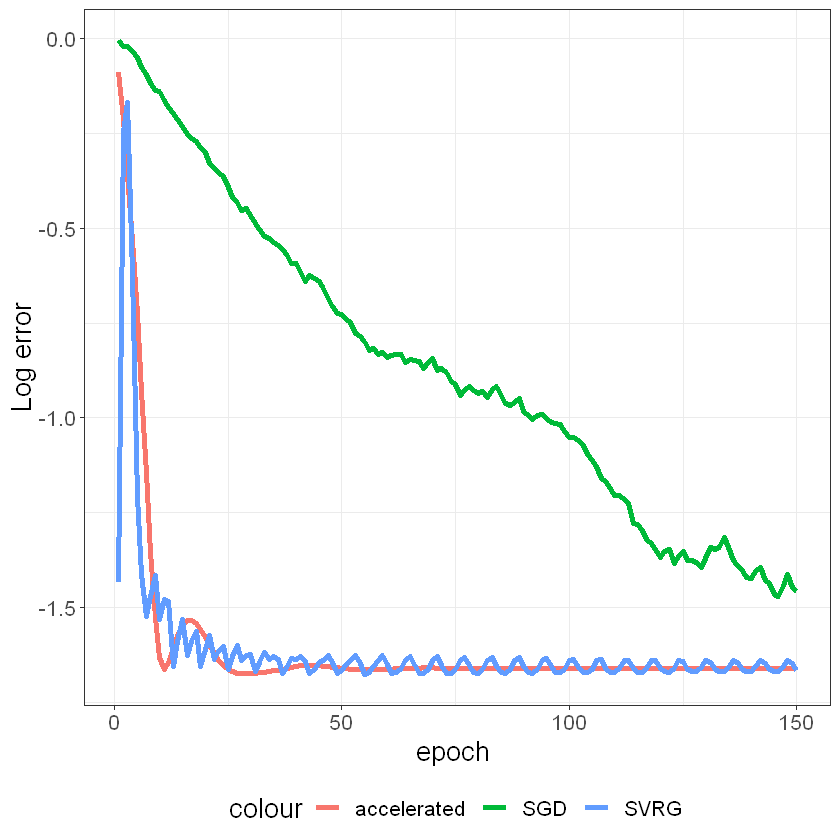

In [586]:
losses <- tibble(n.iter=1:length(model.accelerated$loss),
                 acceleratedGD = model.accelerated$error, 
                 SGD=model.SGD$error,
                 SVRG=model.SVRG$error)
# pdf('stochastic_conv.pdf', width=10, height =6)
ggplot(data=losses, aes(x=n.iter)) +
geom_line(aes(y=acceleratedGD , color='accelerated'), lwd=1.5) +
geom_line(aes(y=SGD , color='SGD'), lwd=1.5) +
geom_line(aes(y=SVRG, color='SVRG'), lwd=1.5) +
ylab('Log error') +
xlab('epoch ') +
theme_bw() +
theme(legend.position='bottom', text = element_text(size = 16))
dev.off()

In [559]:
model.accelerated$beta

[1] 0.1829388 0.1302556 0.2993231 0.2354538 0.2353088 0.2082066 0.2150627
 [8] 0.2168628 0.2047191 0.2015492 0.2091213 0.2958519 0.3020359 0.2766445
[15] 0.2221478 0.2182510 0.1843487 0.2202671 0.1761006 0.2470729

In [534]:
data$beta

[1] 0.2236068 0.2236068 0.2236068 0.2236068 0.2236068 0.2236068 0.2236068
 [8] 0.2236068 0.2236068 0.2236068 0.2236068 0.2236068 0.2236068 0.2236068
[15] 0.2236068 0.2236068 0.2236068 0.2236068 0.2236068 0.2236068